# Tutorial 4: SpaCon for marmoset cortical gene expression and resting-state functional MRI data

In [1]:
import sys
sys.path.append("/mnt/Data16Tc/home/haichao/code/SpaCon_github/SpaCon/SpaCon/")
from scipy.sparse import coo_matrix, save_npz, load_npz
from model.utils import create_spatial_graph_from_anndata, build_connection_graph, neighbor_sample, model_train, model_eval, clustering

from model.Model_Pyg_SpaCon import SpaCon
# from model.r_mcluster import mclust_R

import torch.nn.functional as F
import copy
import datetime
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
from tqdm import tqdm
import pickle
import h5py

import warnings
warnings.filterwarnings("ignore")
mus = 'mouse_3'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)


def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Data preprocessing 

load spatial transcriptomics data

In [2]:
adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster_marmoset/data/marmoset_cortical_5klabel_gene_exp.h5ad') 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  # add this to make the hightly_variable work

n_top_genes = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'x', 'y', 'z'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

build spatial graph

In [3]:
n_neighbors = 10
ST_graph_data, st_adj = create_spatial_graph_from_anndata(adata=adata,  n_neighbors=n_neighbors, spatial_key='spatial')
ST_graph_data

Data(x=[5000, 3000], edge_index=[2, 50000])

load connectivity data and build connection graph

In [4]:
with h5py.File('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster_marmoset/data/sub_all_lh_LR_bolddata_first512_5klabel_corr.mat', 'r') as f:
    print(list(f.keys()))
    marmoset_FC = f['mean_corr_data'][()] 
    print(marmoset_FC.shape)

['mean_corr_data']
(5000, 5000)


In [5]:
thr = 0.26
count = np.sum(marmoset_FC > thr)
total = marmoset_FC.size
ratio = count / total
ratio

0.090077

In [6]:
NT_graph_data = build_connection_graph(adata, marmoset_FC, threshold=thr)
NT_graph_data

Data(x=[5000, 3000], edge_index=[2, 2251936])

In [7]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 20
lr = 0.00001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [512, 128, 64]    
# model
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results_widefield/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|20


100%|██████████| 79/79 [00:05<00:00, 13.88it/s]


epoch:2|20


100%|██████████| 79/79 [00:04<00:00, 15.83it/s]


epoch:3|20


100%|██████████| 79/79 [00:05<00:00, 15.23it/s]


epoch:4|20


100%|██████████| 79/79 [00:05<00:00, 15.20it/s]


epoch:5|20


100%|██████████| 79/79 [00:05<00:00, 15.13it/s]


epoch:6|20


100%|██████████| 79/79 [00:05<00:00, 14.88it/s]


epoch:7|20


100%|██████████| 79/79 [00:05<00:00, 14.80it/s]


epoch:8|20


100%|██████████| 79/79 [00:05<00:00, 14.76it/s]


epoch:9|20


100%|██████████| 79/79 [00:05<00:00, 14.70it/s]


epoch:10|20


100%|██████████| 79/79 [00:05<00:00, 15.04it/s]


epoch:11|20


100%|██████████| 79/79 [00:05<00:00, 14.90it/s]


epoch:12|20


100%|██████████| 79/79 [00:05<00:00, 14.79it/s]


epoch:13|20


100%|██████████| 79/79 [00:05<00:00, 15.13it/s]


epoch:14|20


100%|██████████| 79/79 [00:05<00:00, 14.64it/s]


epoch:15|20


100%|██████████| 79/79 [00:05<00:00, 14.74it/s]


epoch:16|20


100%|██████████| 79/79 [00:05<00:00, 14.98it/s]


epoch:17|20


100%|██████████| 79/79 [00:05<00:00, 14.53it/s]


epoch:18|20


100%|██████████| 79/79 [00:05<00:00, 14.96it/s]


epoch:19|20


100%|██████████| 79/79 [00:05<00:00, 15.03it/s]


epoch:20|20


100%|██████████| 79/79 [00:05<00:00, 14.87it/s]

Training completed! The model parameters have been saved to ./results_widefield/2025_07_11_19_00_47//model_params.pth


In [9]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 15000/15000 [00:03<00:00, 4045.82it/s]

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'x', 'y', 'z'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'feature_spa', 'feature_con'


The clustering results have been saved in ./results_widefield/2025_07_11_19_00_47//feature_add_weight1/Clusters_res0.5/
AnnData object with n_obs × n_vars = 5000 × 3000
    obs: 'x', 'y', 'z', 'clusters'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'louvain', 'clusters_colors'
    obsm: 'spatial', 'feature_spa', 'feature_con', 'feature_add', 'X_umap'
    obsp: 'distances', 'connectivities'


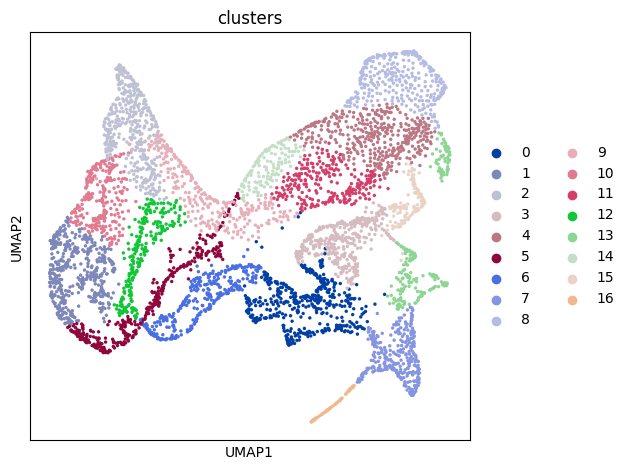

In [11]:
adata = clustering(adata, alpha=1, adata_save_path=results_save_path, cluster_resolution=0.5, 
                   plot_all_cluster_results=False, figsize=figsize, plot_x=plot_x, plot_y=plot_y)

In [12]:
fig_path = './results_widefield/2025_07_11_19_00_47/feature_add_weight1/Clusters_res0.5/'

In [13]:
import nibabel as nib
import pandas as pd

# --------------------- 1. Read parcel label file ---------------------
shape_gii = nib.load('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster_marmoset/surface/surfFS.lh.MBM_cortex_vPaxinos_5klabel.shape.gii')
parcel_labels = shape_gii.darrays[0].data  # Shape: (n_vertices,)

# --------------------- 2. Read cluster labels and convert to integer ---------------------
# Extract cluster label column and convert to integer
cluster_labels_str = adata.obs['clusters'].values  # String format
cluster_labels = cluster_labels_str.astype(int)  # Convert to integer array
cluster_labels = cluster_labels+1
# cluster_labels[cluster_labels != 4] = 0

# --------------------- 3. Map parcel cluster labels to vertices ---------------------
# Initialize vertex cluster label array (background label 0 remains 0)
vertex_clusters = np.zeros_like(parcel_labels, dtype=int)

for parcel_id in range(1, 5001):  # Iterate through parcels 1-5000
    # Find vertex indices belonging to the current parcel
    mask = (parcel_labels == parcel_id)
    # Assign the current parcel's cluster label to these vertices
    vertex_clusters[mask] = cluster_labels[parcel_id - 1]  # DataFrame row index starts from 0

# --------------------- 4. Save as .func.gii file ---------------------
metadata = {
    'AnatomicalStructurePrimary': 'CortexLeft',  # Must be consistent with the surface file
    'GeometricType': 'Functional',  # Set to 'Functional' (original surface file was 'Unknown')
    'Name': 'ClusterLabels',
    'UniqueID': 'CustomID',  # Custom unique ID
}
# Create GIfTI data array
data_array = nib.gifti.GiftiDataArray(
    data=vertex_clusters,
    intent='NIFTI_INTENT_NONE',  # Or 'NIFTI_INTENT_LABEL' (depending on data type)
    datatype='NIFTI_TYPE_INT32',
    meta=nib.gifti.GiftiMetaData(metadata)  # Add metadata
)

# Create GIfTI image object and save
func_gii = nib.gifti.GiftiImage(darrays=[data_array])
nib.save(func_gii, fig_path + 'cluster_labels.func.gii')